# Sentiment Analysis of Tweets (TweetEval Sentiment Task)

_Sentiment analysis_ in natural language processing refers to the analysis of the _polarity_ (positivity vs. negativity) of text. Polarity analysis can be as simple as the binary positive vs. negative, or can be refined into several classes (e.g., very positive, slightly positive, neutral, slightly negative, strongly negative; 1 - 5 stars in Yelp or Amazon reviews, etc.).

This notebook explores sentiment analysis of the TweetEval Sentiment Analysis corpus ([cardiffnlp, 2020](https://github.com/cardiffnlp/tweeteval)) of almost 60,000 tweets on a variety of subjects. This will be referred to as the TweetEval-SA corpus in the remainder of this notebook. Latent Dirichlet Allocation topic models will be developed for negative, neutral, and positive tweets. Polarity classifiers will be trained, then evaluated against the corpus' test set.

In [26]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from enum import IntEnum
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import re
import string

import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel 
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Read the data
DATA_DIR = './fixed/'

def get_tweets(tweet_file):
    "Returns a dataframe with single column named Tweet"
    file_path = path.join(DATA_DIR, tweet_file)
    # tweets can have commas, so we don't want to use pd.read_csv
    with open(file_path, encoding='UTF-8') as t_file:
        tweets = [tw.strip() for tw in t_file]
    df = pd.DataFrame(tweets, columns = ['Tweet'], dtype=np.str)
    return df

def get_labels(label_file):
    """Returns dataframe with single column named Polarity. Subtracts one so
    negative, neutral, positive = -1, 0, 1"""
    file_path = path.join(DATA_DIR, label_file)
    df = pd.read_csv(file_path, names = ['Polarity'], sep = '\t', dtype=np.short)
    df.Polarity -= 1
    return df.Polarity.to_list()

TRAIN_TWEETS = 'train_text.txt'
TRAIN_LABELS = 'train_labels.txt' 
VAL_TWEETS = 'val_text.txt' 
VAL_LABELS = 'val_labels.txt' 
TEST_TWEETS = 'test_text.txt' 
TEST_LABELS = 'test_labels.txt' 

df_tweets_train = get_tweets(TRAIN_TWEETS)
df_tweets_val = get_tweets(VAL_TWEETS)
df_tweets_test = get_tweets(TEST_TWEETS)
Y_train = get_labels(TRAIN_LABELS)
Y_val = get_labels(VAL_LABELS)
Y_test = get_labels(TEST_LABELS)

# Combine the tweets to make pre-processing easier. We will re-segment into train/validation/test sets afterwards.
df_tweets = pd.concat([df_tweets_train, df_tweets_val, df_tweets_test], ignore_index = True)
Y_all = Y_train + Y_val + Y_test
assert len(df_tweets) == len(Y_all)


In [3]:
total = len(Y_all)
print("Number of examples")
print("======================")
print("Train\t\t", len(Y_train), f" ({len(Y_train)/total:03.0%})")
print("Validation\t ", len(Y_val), f" ({len(Y_val)/total:03.0%})")
print("Test\t\t", len(Y_test), f" ({len(Y_test)/total:03.0%})")
print("----------------------")
print("Total\t\t", len(Y_all), f"({1:.0%})")

Number of examples
Train		 45545  (76%)
Validation	  2000  (03%)
Test		 12100  (20%)
----------------------
Total		 59645 (100%)


## Data Description

The 59,645 documents in the TweetEval-SA corpus are public tweets that appeared on Twitter in 2016. User handles have been anonymized in order to respect the privacy of Twitter users. The corpus has been partitioned into a training set (76%), validation set (3%), and test set(20%). 

## Tweet Pre-Processing

Natural language passages tend to be very noisy. Differing capitalization, regional spelling and vocabulary variants, synonyms, lingo, punctuation, and numerous other language oddities make analysis very difficult. Tweets are especially noisy, as seen in some training examples below:

In [4]:
for i in [8, 51, 36, 12, 81, 115]:
    print(df_tweets_train.Tweet[i])

Former Minister & SLFP member Najeeb A Majeed may appoint as CM of the Eastern Province. But, can't confirm the news still
I GET TO GO SEE SHAWN ON WEDNESDAY IM SO HAPPY @user H-town is going to be lit
Sprint getting Samsung Galaxy Tab 2 10.1 with LTE support, on November 11th: The first LTE enabled... <--Full Story
$1 daiquiris at Rum Runners tonight and I don't have class til 2 tomorrow..... Yesssss!
Why these mfs jus blastin \""Rella\"" like itz the hood on Saturday N shit lolz smh
[http://t.co/2iAIexuu4u]  Mets' David Wright on stretch run: 'I'm going to enjoy this'  (Mon, 7 Sep 2015


In the first two sentences, capitalization is used both to signify an acronym (_SLFP_ = Sri Lanka Freedom Party) and an enhanced emotion (_I GET TO GO_). In the third and fourth sentences, numbers can signify a product release, a date, a time of day, or the cost of a daiquiri at Rum Runners. In the final two sentences, letters are repeated for emphasis (_Yesssss_), online lingo is seen (_itz, lolz, smh_), and URLs refer to meaningful text or visual context. Other tweet vagaries such as hashtags and user handles could be mentioned as well.

To reduce the noise in this dataset, [a Python port](https://gist.github.com/tokestermw/cb87a97113da12acb388) of [the Stanford NLP twitter-preprocess script](https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb) has been supplemented with the removal of punctuation (other than <, >, ?, and !) and a refinement of the all-caps logic. After this pre-processing, the tweets will be ready for word embeddings with [the Stanford NLP Twitter GLOVE dictionary](https://nlp.stanford.edu/projects/glove/) or, after stop word removal, for more conventional vectorizations such as bag-of-words or term frequency-inverse document frequency.

Prior to the standard pre-processing, however, some text encoding issues that were not gracefully handled in the TweetEval SA datasetmust first be addressed.

In [4]:
def fix_encoding(text):
    text = text \
            .replace(r"\u2019", "'") \
            .replace(r"\u002c", "'") \
            .replace(r'\"', '') \
            .replace("&amp;", '&') \
            .replace("&gt;", '>') \
            .replace("&lt;", '<') \
            .replace("&#160;", ' ') \
            .replace("&#039;", "'") \
            .replace("&#39;", "'") \
            .replace("&#038;", "&") \
            .replace("&#38;", "&")
    return text

df_tweets['Tweet'] = df_tweets.Tweet.apply(fix_encoding)

### Pre-processing steps

The pre-processing steps used in this experiment are as follows:

1. URL handling
2. Slash handling
3. User handling
4. Emoticon handling
5. Disambiguation of _#1_ ("number one") from hashtags
6. Number handling
7. Hashtag handling
8. Punctuation repetition
9. Word elongation handling
10. All-caps word handling
11. Removal of most punctuation
12. Word tokenization
13. Stopword removal (customized for sentiment analysis)

While stemming or lemmatization are frequently used in NLP pre-processing, [Bao, et al.](https://doi.org/10.1007/978-3-319-09339-0_62) report that these techniques decrease the performance of statistical sentiment analysis models on Twitter data. Therefore the pre-processing pipeline in this experiment does not use stemming or lemmatization.


In [76]:
###########################################################################/
#    Title: Python version of Ruby script 
#           to preprocess tweets for use in GloVe featurization
#    Author: Motoki Wu (@tokestermw)
#    Date: 2017
#    Availability: https://gist.github.com/tokestermw/cb87a97113da12acb388
#
###########################################################################/

# Adaptations by Chris Falter
# 1. Improved all-caps regex 
# 2. Add a space between a word and trailing ? or !

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body)
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"

# BEGIN Falter Adaptation
clause_ending_punctuation = r',{;?}\^\-`/.|%=~<_#!$+*@"&:\[\]\(\)'

def insert_space(text):
    text = text.group()
    return text[0] + ' ' + text[1]
# END Falter Adaptation 

def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    #BEGIN Falter
    text = re_sub(r"\b#1\b", "number_one")
    #END Falter
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    # BEGIN Falter Adaptation
    #text = re_sub(r"([A-Z]){2,}", allcaps) 
    text = re_sub(r"(\b|^)([A-Z]){2,}(\b|$)", allcaps)
    # twitter users frequently run words and punctuation together. Let's make sure the reserved words
    # don't bleed into following text
    text = re_sub(r">\S", insert_space)
    # detach words from clause-ending punctuation
    text = re_sub(f"[A-Za-z]{{1}}[{clause_ending_punctuation}]{{1}}", insert_space)
    # END Falter Adaptation 

    return text.lower()

df_tw_glove_preproc = df_tweets.copy()
df_tw_glove_preproc['Tweet'] = df_tw_glove_preproc.Tweet.apply(tokenize)

Now the data are ready for the final pre-processing steps: 
* removal of unnecessary punctuation, keeping only `?`, `!`, and brackets in reserved words like `<smile>`;
* word tokenizing; and 
* stopword removal. 

Note that negation stopwords are _not_ removed because they may affect sentiment analysis; for example, it would not be desirable to remove _not_ from the phrase "not happy."

In [79]:
essential_punc = "<>?!"
special_punc = ".-+()[]"
unnecessary_punc = ''.join(set(string.punctuation) - set(essential_punc) - set(special_punc))
unnecessary_punc += '\.\-\+\(\)\[\]'

def remove_brackets(text):
    text = text.group()
    return re.sub(r"[<>]", '', text)

def remove_unnecessary_punctuation(text):
    text = re.sub(f"[{unnecessary_punc}]", '', text, flags=FLAGS)
    # remove brackets that are not in reserved tokens such as '<smile>'
    text = re.sub(r"<[^aehlnrsu]|[^eglrst]>", remove_brackets, text, flags=FLAGS)
    return text

def convert_reserved_words(text):
    return re.sub(r"(<\w+>)", 
                    lambda text: text.group().replace('<', '_').replace('>', '_'), 
                    text, 
                    flags=FLAGS)

negations = set(("but", "no", "nor", "not"))
stop_words = set(stopwords.words('english'))
stop_words -= negations

def remove_stopwords(tokens):
    return [tok for tok in tokens if tok not in stop_words]

df_tokenized = df_tw_glove_preproc.copy()
df_tokenized['Tweet'] = df_tokenized.Tweet.apply(remove_unnecessary_punctuation)
df_tokenized['Tweet'] = df_tokenized.Tweet.apply(convert_reserved_words)
df_tokenized['Tweet'] = df_tokenized.Tweet.apply(word_tokenize)
df_tokenized['Tweet'] = df_tokenized.Tweet.apply(remove_stopwords)

## Data Vectorization

To use a cleaned, tokenized tweet in a prediction model, it must be vectorized--i.e., transformed into numerical vector format. After splitting the dataset back into its train, validation, and test segments, the text will be  vectorized with the bag-of-words (BOW) method implemented in `sklearn.feature_extraction.text.CountVectorizer`. In the sentiment analysis section of this notebook, experimentatio with 2-grams along will be used in order to detect negations such as "not happy." To keep things simple for the next section (topic analysis), text will be vectorized with unigrams in this section.

In [80]:
# reassemble word-tokens back into strings that can be consumed by gensim and sklearn APIs
df_reassembled = df_tokenized.copy()
df_reassembled['Tweet'] = df_reassembled.Tweet.apply(lambda tokens: ' '.join(tokens))
df_reassembled_train = df_reassembled.iloc[:len(Y_train)]
unigram_counter = CountVectorizer()
X_train = unigram_counter.fit_transform(df_reassembled_train.Tweet)

In [14]:
print(X_train[0:2])

  (0, 4961)	1
  (0, 31121)	1
  (0, 38267)	1
  (0, 20281)	1
  (0, 38482)	1
  (0, 14519)	1
  (0, 35602)	1
  (0, 7)	1
  (0, 28720)	1
  (0, 38536)	1
  (0, 13210)	1
  (1, 7)	1
  (1, 26113)	1
  (1, 27181)	1
  (1, 25488)	1
  (1, 12035)	1
  (1, 17102)	1
  (1, 34651)	1
  (1, 11550)	1
  (1, 37988)	1
  (1, 26179)	1


The `CountVectorizer` represents the data as a _sparse matrix_. The coordinates (e.g., "(0, 4961)" in the first row) are represented by a tuple of the document (tweet) index and vocabulary index. The term frequency is `1` for each vocabulary word in the first two tweets, which is not unexpected due to the very short length of tweets. A longer document would be expected to have many terms with a frequency greater than 1.

## Sentiment Labels

Over the entire dataset (including train, validation, and test segments), the sentiment polarity breaks down as follows:
* Negative: 19%
* Neutral: 46%
* Positive: 35%

In [8]:
class POLARITY(IntEnum):
    negative = -1
    neutral = 0
    positive = 1

c = Counter(Y_all)
print("Negative", f"{c[POLARITY.negative]/total:03.0%}")
print("Neutral\t", f"{c[POLARITY.neutral]/total:03.0%}")
print("Positive", f"{c[POLARITY.positive]/total:03.0%}")

Negative 19%
Neutral	 46%
Positive 35%


## Topic Analysis by Polarity

Daily experience suggests that some topics are more likely to incite positive or negative sentiments than others. Consequently, it is possible that topics discussed in negative tweets are different from those in discussed in positive tweets. This hypothesis can be tested by performing a topic analysis of the three dataset segments (negative, neutral, and positive). 

In [10]:
id2word = corpora.Dictionary(df_tokenized.Tweet)

In [33]:
df_Y_all = pd.DataFrame(Y_all, columns = ["Polarity"])
df_neg = df_tokenized[df_Y_all.Polarity == POLARITY.negative]
bow_negative = [id2word.doc2bow(tw) for tw in df_neg.Tweet]
df_neutral = df_tokenized[df_Y_all.Polarity == POLARITY.neutral]
bow_neutral = [id2word.doc2bow(tw) for tw in df_neutral.Tweet]
df_pos = df_tokenized[df_Y_all.Polarity == POLARITY.positive]
bow_positive = [id2word.doc2bow(tw) for tw in df_pos.Tweet]

In [46]:
seed = 42
def find_optimal_lda(bow, tweet_series, min_topics, max_topics):
    best_coherence = 0.0
    best_num_topics = 0
    best_model = None
    for i in range(min_topics, max_topics + 1):
        lda_model = LdaModel(corpus=bow,
                            id2word=id2word,
                            num_topics=i, 
                            random_state=seed,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)
        coherence_model = CoherenceModel(
            model=lda_model, 
            texts=tweet_series, 
            dictionary=id2word, 
            coherence='c_v',
            processes=2,
            )
        coherence_score = coherence_model.get_coherence()
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_num_topics = i
            best_model = lda_model
    print(f"coherence score: {best_coherence:.2}, num topics = {best_num_topics}")
    return best_model

print("Negative")
neg_lda = find_optimal_lda(bow_negative, df_neg.Tweet, 3, 10)
print()
print("Neutral")
neutral_lda = find_optimal_lda(bow_neutral, df_neutral.Tweet, 3, 10)
print()
print("Positive")
pos_lda = find_optimal_lda(bow_positive, df_pos.Tweet, 3, 10)

Negative
coherence score: 0.6, num topics = 7

Neutral
coherence score: 0.54, num topics = 6

Positive
coherence score: 0.58, num topics = 7


### Topic Visualization by Polarity

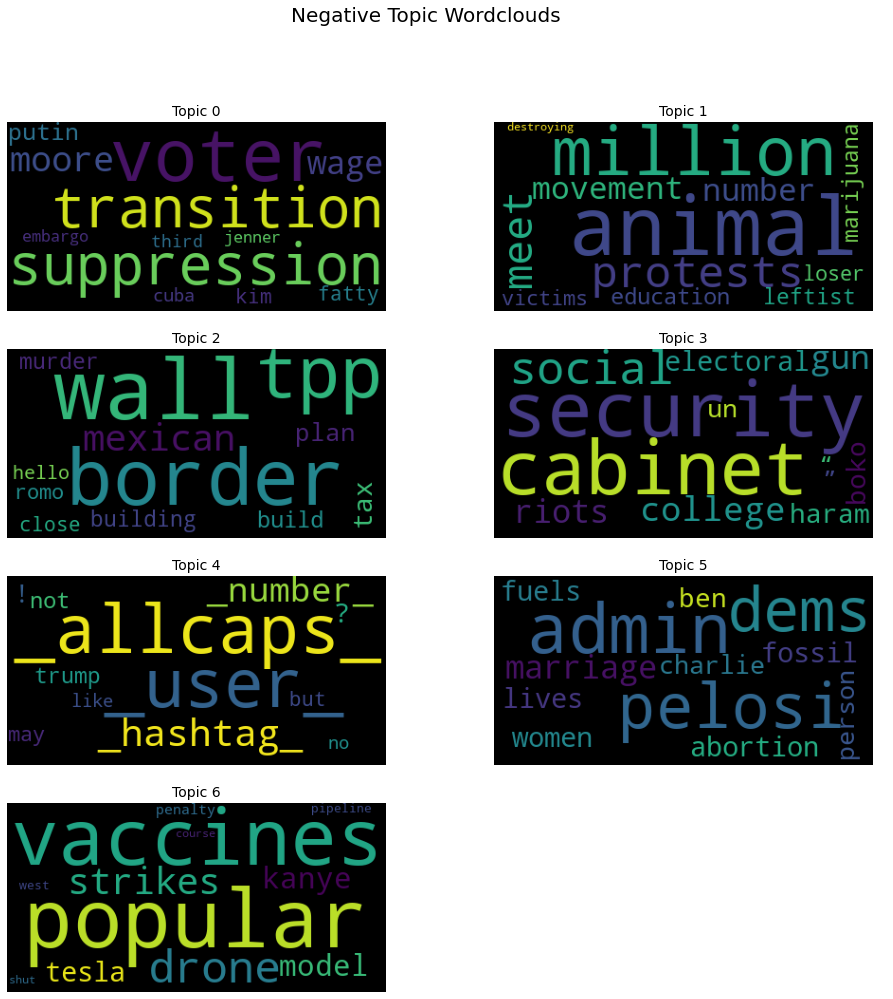

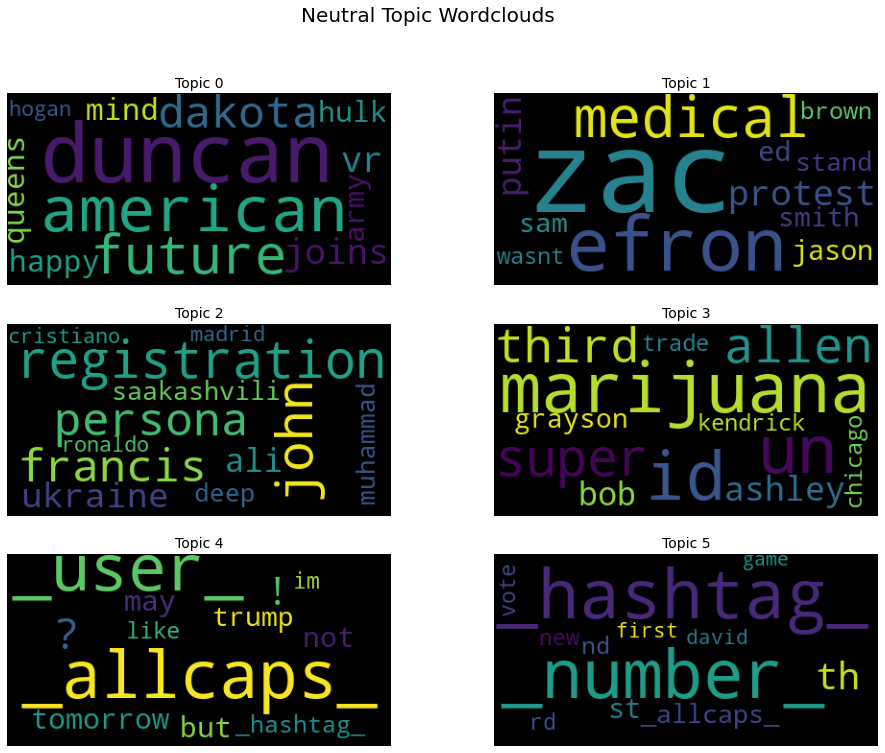

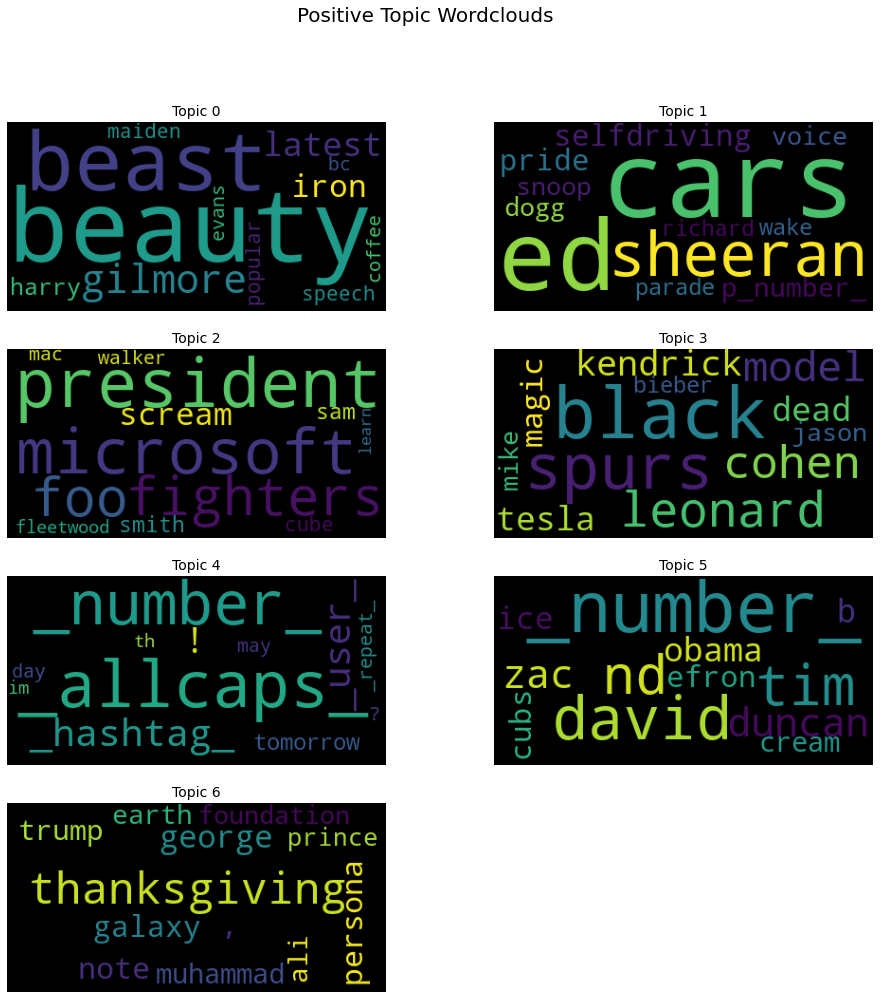

In [74]:
def display_polarity_topic_wordclouds(polarity, lda, figsize, rows, cols=2, num_words = 12):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    fig.suptitle(f"{polarity} Topic Wordclouds", fontsize=20)
    axes = axes.flatten()
    for t in range(lda.num_topics):
        w = WordCloud()
        freqs = {k:v for (k, v) in lda.show_topic(t, num_words)}
        axes[t].imshow(w.fit_words(freqs))
        axes[t].set_title(f"Topic {t}", fontsize=14)
        axes[t].axis('off')
    num_subplots = rows * cols
    if lda.num_topics < num_subplots:
        axes[num_subplots - 1]. axis('off')

display_polarity_topic_wordclouds("Negative", neg_lda, (16, 16), 4)
display_polarity_topic_wordclouds("Neutral", neutral_lda, (16, 12), 3)
display_polarity_topic_wordclouds("Positive", pos_lda, (16, 16), 4)


### Analysis of Topics by Polarity

The hypothesis of differing topics by polarity is supported by the preceding topic analysis. 

Among *political personalities*, we see that Obama shows up only in positive topics. Trump, figuring in all three polarities, is more controversial. Pelosi draws a lot of criticism, showing up only in a negative topic. 

With regard to political themes, we see that some terms like "leftist" (as opposed to the alternative "progressive") "dems" (vs. "democrats"), and "abortion" (vs. "choice") are used by critics, while "president" is a term of positive respect. Border/trade policies, voter suppression, violent Islamists, and fossil fuels draw notable criticism. International news topics like Ukraine and Putin tend seem to be reported in a largely neutral fashion.

Sports personalities and teams are generally found only in neutral or positive topics. But let us pity poor Tony Romo, quarterback of the Dallas Cowboys, who must have ended the season badly; he is the only sports personality to appear on the negative polarity side.

Some technologies (vaccines, Tesla, drones) are the subject of criticism, while others (self-driving cars) are praised.

Entertainment (movies and personalities) are typically regarded as neutral or positive, but Kanye and Kim (Kardashian) seem to invite more criticism than praise.

## Splitting Data into Train and Test Sets

The TweetEval Sentiment Analysis dataset has already been partitioned into train, validation, and test sets. The train and validation sets will be combined into a single training set, and cross-validation will be used to optimize prediction models. The TweetEval test set will be used to evaluate the support vector machine, logistic regression, and Naive Bayes classification models.

In [81]:
# train set has already been re-captured
df_reassembled_train = df_reassembled.iloc[: len(Y_train) + len(Y_val)]
df_reassembled_test = df_reassembled.iloc[len(Y_train) + len(Y_val):]
combined_Y_train = Y_train + Y_val
assert len(df_reassembled_train) == len(combined_Y_train)
assert len(df_reassembled_test) == len(Y_test)

## Sentiment Analysis

In this phase, prediction models will be trained using bag-of-words and TF-IDF vector representations. The `sklearn.model_selection.GridSearchCV` API will be used to optimize model accuracy via cross-validation. Because TweetEval-SA uses the metric of macro-averaged recall (M-Rec) rather than accuracy or F1 score, using M-Rec to optimize models will facilitate comparison with the results reported in the TweetEval paper.

### Naive Bayes Model

In [89]:
rec_mac = make_scorer(recall_score, average='macro')
f1 = make_scorer(f1_score, average='macro')

nb_pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', MultinomialNB()),
])

nb_param_grid = {
    'vect__max_df': [0.1, 0.12, 0.14, 0.16, 0.18],
    'vect__min_df': [0.],
    'vect__ngram_range': [(1, 2)], 
    'vect__use_idf': [False],
    'clf__alpha': [ 0.04, 0.027, 0.014],
}

nb_gs = GridSearchCV(nb_pipeline, nb_param_grid, scoring=f1, n_jobs=5, verbose=0)
_ = nb_gs.fit(df_reassembled_train.Tweet, combined_Y_train)

### Logistic Regression Model

In [90]:
lr_pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', LogisticRegression()),
])

lr_param_grid = {
    'vect__max_df': [0.1, 0.11, 0.12, 0.13],
    'vect__min_df': [0.],
    'vect__ngram_range': [(1, 2)], 
    'vect__use_idf': [False],
    'clf__C': [7., 8.5, 10.],
}

lr_gs = GridSearchCV(lr_pipeline, lr_param_grid, scoring=f1, n_jobs=5, verbose=0)
_ = lr_gs.fit(df_reassembled_train.Tweet, combined_Y_train)

In [91]:
val_f1 = max(nb_gs.cv_results_['mean_test_score'])
print(f"Naive Bayes validation F1 score = {val_f1:.2%}")
val_f1 = max(lr_gs.cv_results_['mean_test_score'])
print(f"Logistic regression validation F1 score = {val_f1:.2%}")

Naive Bayes validation F1 score = 55.62%
Logistic regression validation F1 score = 62.83%


### Support Vector Machine Model

Since the SVM is so slow to train (compared to other statistical learning models), the best vectorizer hyperparameters from the logistic regression grid search will be adopted. Only SVM parameters will be varied in the grid search. 

In [93]:
print("Naive Bayes Best Parameters")
print(nb_gs.best_params_)
print()
print("Logistic Regression Best Parameters")
print(lr_gs.best_params_)

Naive Bayes Best Parameters
{'clf__alpha': 0.014, 'vect__max_df': 0.14, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 2), 'vect__use_idf': False}

Logistic Regression Best Parameters
{'clf__C': 7.0, 'vect__max_df': 0.1, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 2), 'vect__use_idf': False}


In [94]:
seed = 42
svm_pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', SVC()),
])

svm_param_grid = {
    'vect__max_df': [0.1],
    'vect__min_df': [0.],
    'vect__ngram_range': [(1, 2)], 
    'vect__use_idf': [False],
    'clf__C': [2., 4., 6., 8.],
    'clf__random_state': [seed]
}

svm_gs = GridSearchCV(svm_pipeline, svm_param_grid, scoring=f1, n_jobs=5, verbose=0)
_ = svm_gs.fit(df_reassembled_train.Tweet, combined_Y_train)

In [95]:
print("SVM Best Parameters")
print(svm_gs.best_params_)
print()
val_f1 = max(svm_gs.cv_results_['mean_test_score'])
print(f"SVM validation M-Rec score = {val_f1:.2%}")

SVM Best Parameters
{'clf__C': 8.0, 'clf__random_state': 42, 'vect__max_df': 0.1, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 2), 'vect__use_idf': False}

SVM validation M-Rec score = 62.11%


### Performance on Test Set

In this section, accuracy score will be used to rank the three models (Naive Bayes, Logistic Regression, and SVM). Confusion matrices will supply additional insight into model performance; for example, a model that confuses positive with negative polarity would be less useful than a model that confuses positive with neutral, even if the two models had the same accuracy.

In [96]:
nb_clf = nb_gs.best_estimator_
lr_clf = lr_gs.best_estimator_
svm_clf = svm_gs.best_estimator_

y_nb = nb_clf.predict(df_reassembled_test.Tweet)
y_lr = lr_clf.predict(df_reassembled_test.Tweet)
y_svm = svm_clf.predict(df_reassembled_test.Tweet)

metrics = {
    "Classifier": ["NB", "LR", "SVM"],
    "Accuracy": [f"{accuracy_score(Y_test, y_nb):.2%}", 
                f"{accuracy_score(Y_test, y_lr):.2%}",
                f"{accuracy_score(Y_test, y_svm):.2%}"],
    "F1": [f"{f1_score(Y_test, y_nb, average='macro'):.2%}",
            f"{f1_score(Y_test, y_lr, average='macro'):.2%}",
            f"{f1_score(Y_test, y_svm, average='macro'):.2%}"],
    "M-Rec":[f"{recall_score(Y_test, y_nb, average='macro'):.2%}",
             f"{recall_score(Y_test, y_lr, average='macro'):.2%}",
             f"{recall_score(Y_test, y_svm, average='macro'):.2%}"]
}

results_df = pd.DataFrame(metrics)
print(results_df)


  Classifier Accuracy      F1   M-Rec
0         NB   54.73%  52.72%  53.61%
1         LR   58.55%  57.30%  58.27%
2        SVM   59.40%  56.85%  57.02%


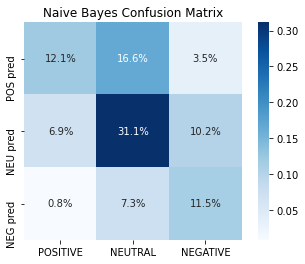

In [97]:
cm_nb = confusion_matrix(Y_test, y_nb)
cm_lr = confusion_matrix(Y_test, y_lr)
cm_svm = confusion_matrix(Y_test, y_svm)

def display_confusion_matrix(model_name, cm):
    df = pd.DataFrame(
        cm, 
        index=["POS pred", "NEU pred", "NEG pred"],
        columns=["POSITIVE", "NEUTRAL", "NEGATIVE"]
        )
    df = df / len(Y_test)
    sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
    title = f"{model_name} Confusion Matrix"
    plt.title(title)

display_confusion_matrix("Naive Bayes", cm_nb)

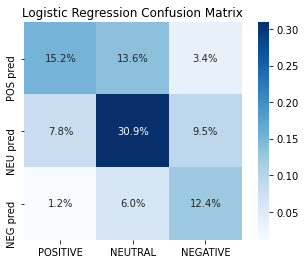

In [98]:
display_confusion_matrix("Logistic Regression", cm_lr)

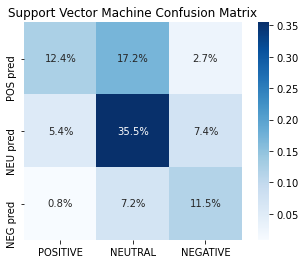

In [99]:
display_confusion_matrix("Support Vector Machine", cm_svm)

## Conclusion

The logistic regression (LR) model achieved the best performance as measured by F1 score and macro-averaged recall score. As expected, the confusion between positive and negative classes was negligible (4.6%). The LR model has a slight positive bias; the most common error was a false positive prediction of neutral examples (13.6%), followed at some distance by neutral prediction of negative examples (9.5%).

The LR model was somewhat overfitted to the training set; F1 score dropped from 62.80% on validation to 58.2% on the test set. Further experimentation with regularization and vectorization hyperparameters is warranted.

As measured by M-Rec, the LR model's performance was in line with the baseline results of statistical models reported in the TweetEval paper ([Barbieri, et al., 2020](https://arxiv.org/pdf/2010.12421.pdf)):

Model | Test F1-score
----- | -------------
LR (this experiment) | 58.3%
SVM (baseline) | 62.9%
FastText (baseline) | 62.9%
Bidirectional LSTM (baseline) | 58.3%
Rob-RT (baseline) | 72.6%

`Rob-RT` refers to the neural attention model _RoBERTa - Retrained on Twitter_ that achieves the benchmark performance in the TweetEval paper ([Barbieri, et al., 2020](https://arxiv.org/pdf/2010.12421.pdf)). The large gap between the benchmark Rob-RT model and the statistical models suggests that the combination of its neural attention architecture and its multi-task training permit it to learn features that are more useful than those meticulously crafted by programming code in this experiment.

## References

Bao Y., Quan C., Wang L., Ren F. (2014) The Role of Pre-processing in Twitter Sentiment Analysis. In: Huang DS., Jo KH., Wang L. (eds) Intelligent Computing Methodologies. ICIC 2014. Lecture Notes in Computer Science, vol 8589. Springer, Cham. https://doi.org/10.1007/978-3-319-09339-0_62

Barbieri, F., Camacho-Collados, J., Anke, L. E., & Neves, L. (2020). TweetEval: Unified Benchmark and Comparative Evaluation for Tweet Classification. Findings of the Association for Computational Linguistics: EMNLP 2020. doi:10.18653/v1/2020.findings-emnlp.148 

cardiffnlp. (2020). Cardiff University TweetEval Repository. Retrieved December 14, 2020, from https://github.com/cardiffnlp/tweeteval

Wu, Motoki (2017) Python version of Ruby script to preprocess tweets for use in GloVe featurization [Source code]. https://gist.github.com/tokestermw/cb87a97113da12acb388



In [35]:
word_b4_punc_pattern = re.compile(f"[A-Za-z][{clause_ending_punctuation}]")

error: nothing to repeat at position 34

In [38]:
f"[A-Za-z][{clause_ending_punctuation}]"

'[A-Za-z][,{;?[}\\^-`/.)|%](=~<_>#!$+*\'@"&:\\[\\]]'

In [49]:
pattern = re.compile(''.join(set(string.punctuation) - set("'[]()")) + "\[\]\(\)")


error: nothing to repeat at position 21

In [52]:
''.join(set(string.punctuation) - set("'[]()")) + r"\[\]\(\)"

',{;?}\\^-`/.|%=~<_>#!$+*@"&:\\[\\]\\(\\)'

In [56]:
ptn = re.compile(r'[,{;?}\^\-`/.|%=~<_>#!$+*@"&:\[\]\(\)]')

In [58]:
ptn.sub('', "hello,{;?}^-`/.|%=~<_>#!$+*@""&:[]() world")

'hello world'

In [77]:
df_tw_glove_preproc.Tweet[:6]

0    broncineers ! remember that tomorrow we have t...
1    not to be outdone by the neighbours , erdogan ...
2    katy perry - "you just gotta ignite the light ...
3    who's going to concords football game this sat...
4    do you own a business in bolder ? then you may...
5    so , as someone who just got the game of thron...
Name: Tweet, dtype: object

In [75]:
clause_ending_punctuation = r',{;?}\^\-`/.|%=~<_#!$+*@"&:\[\]\(\)'
text = "broncineers] remember"
re.sub(f"[A-Za-z]{{1}}[{clause_ending_punctuation}]{{1}}", insert_space, text, flags=FLAGS)

'broncineers ] remember'